<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера</b>
    
    
Привет! Меня зовут Даниил Вяжев, я буду проверять твой проект. Если не против, давай общаться на «ты». Если тебе такой стиль общения не нравится, напиши об этом, будем на «вы».

Сразу хочу обратить внимание на цветовую разметку:

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Зеленым с пометкой ✔️ отмечены отличные решения и идеи, которые можно и нужно использовать в будущем.
</div>
    
<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Желтым с пометкой ⚠️ отмечено то, что можно или нужно оптимизировать, в зависимости от контекста.</div>    
    
<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Красным с пометкой ❌ обозначены пропущенные пункты задания и ошибки, которые обязательно надо будет исправить, чтобы результаты были верные.</div> 
    
**Ответы на мои комментарии или доработки по моим рекомендациям попрошу выделить каким-нибудь цветом, кроме перечисленных.**
Также я попрошу тебя **не менять, не передвигать и не удалять мои комментарии**, чтобы при последующей проверке мне было проще ориентироваться.
        
<hr>
    
<font color= 'dodgerblue'>**По проекту:**</font> 
    
    
Поздравляю тебя с успешным завершением работы над этим этапом проекта!
    
Ты создала полноценный пайплайн рекомендательной системы production-уровня. Я увидел понимание важных аспектов работы с большими данными от эффективного управления памятью через правильные типы данных и ленивую загрузку до алгоритмических оптимизаций с использованием argpartition и битовой упаковки. Отметил правильный баланс между производительностью и читаемостью кода, это похвально. 
    
Единственная существенная проблема - утечка данных при создании признаков. Продолжай в том же духе!
    
<hr style="border-top: 3px solid purple; "></hr>
Комментарии можешь оставлять с помощью такого кода в Markdown ячейке:
    
    
    <div class="alert alert-info">
    <h2> Комментарий студента</h2>


    Тут текст.
    </div>
    
    
    <font color='red'> Этот код позволяет менять цвет текста. </font>     


  

О том, как **форматировать текст** в Markdown ячейке или как добавлять ссылки, ты можешь узнать [тут](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet) и [вот тут](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).




Желаю удачи!


<img src="https://user-images.githubusercontent.com/74038190/225813708-98b745f2-7d22-48cf-9150-083f1b00d6c9.gif" width="500">
</div>    



# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [ ]:
import os
import gc
import json
from pathlib import Path
from functools import lru_cache
from dataclasses import dataclass
from typing import Iterator, Iterable, Optional, Sequence

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import boto3
from boto3.s3.transfer import TransferConfig
from botocore.exceptions import ClientError

import psutil
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares

import lightgbm as lgb
from dotenv import load_dotenv

from config import CFG, RNG
import logging

logging.basicConfig(
    level=CFG.LOG_LEVEL,
    format="%(asctime)s | %(levelname)-7s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)


load_dotenv()

/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [10]:
# small utils

def ram_gb() -> float:
    return float(psutil.virtual_memory().available / 1024**3)

def cleanup(*variable_names: str) -> None:
    for variable_name in variable_names:
        if variable_name in globals():
            del globals()[variable_name]
    gc.collect()

def ensure_dir(path: Path | str) -> None:
    Path(path).mkdir(parents=True, exist_ok=True)

def require_env(name: str) -> str:
    value = os.getenv(name)
    if not value:
        raise RuntimeError(f"missing required env variable: {name}")
    return value

def read_parquet(path: Path | str) -> pd.DataFrame:
    return pd.read_parquet(path)

def read_parquet_lazy(
    path: Path | str,
    *,
    columns: Optional[list[str]] = None,
    batch_size: int = 200_000,
) -> Iterator[pd.DataFrame]:
    with pa.OSFile(str(path), "rb") as file_handle:
        parquet_file = pq.ParquetFile(file_handle)
        for record_batch in parquet_file.iter_batches(columns=columns, batch_size=batch_size):
            batch_df = record_batch.to_pandas(ignore_metadata=True)
            if not batch_df.empty:
                yield batch_df

def iter_tables(data: pd.DataFrame | pa.Table | Iterable[pd.DataFrame | pa.Table]) -> Iterator[pa.Table]:
    if isinstance(data, (pd.DataFrame, pa.Table)):
        data = [data]
    for batch in data:
        if isinstance(batch, pd.DataFrame):
            if not batch.empty:
                yield pa.Table.from_pandas(batch, preserve_index=False)
        elif isinstance(batch, pa.Table):
            if batch.num_rows:
                yield batch
        else:
            raise TypeError(f"unsupported batch type: {type(batch)!r}")

def same_schema(a: pa.Schema, b: pa.Schema) -> bool:
    return len(a) == len(b) and all(
        af.name == bf.name and af.nullable == bf.nullable and af.type.equals(bf.type)
        for af, bf in zip(a, b)
    )

def save_parquet(
    data: pd.DataFrame | pa.Table | Iterable[pd.DataFrame | pa.Table],
    path: Path | str,
    *,
    row_group_size: int = 1_000_000,
) -> Path:
    path = Path(path)
    ensure_dir(path.parent)

    tables_iter = iter(iter_tables(data))
    first_table = next(tables_iter, None)
    if first_table is None:
        raise ValueError(f"nothing to write: {path}")

    schema = first_table.schema
    with pq.ParquetWriter(str(path), schema, compression="snappy") as writer:
        writer.write_table(first_table, row_group_size=row_group_size)
        for table in tables_iter:
            if not same_schema(table.schema, schema):
                raise ValueError("schema mismatch (name/type/nullable differ)")
            writer.write_table(table, row_group_size=row_group_size)

    return path

def pack_u64(user_ids_u32: np.ndarray, track_ids_u32: np.ndarray) -> np.ndarray:
    return (user_ids_u32.astype(np.uint64, copy=False) << 32) | track_ids_u32.astype(np.uint64, copy=False)

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Если на вход подается пустой итератор, функция создаст пустой файл без схемы.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Правильный паттерн для работы с огромными датасетами без перегрузки памяти.



<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
В функции read_parquet_lazy не закрывается ParquetFile, это может привести к утечке ресурсов.

<div class="alert alert-info" role="alert" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента </b>
    
Добавила контекстный менеджер для закрытия файлового дескриптора в read_parquet_lazy. </hr>
Пустые батчи пропускаются, а если после фильтрации нечего записывать, функция падает. </hr>
Схема фиксируется по первому непустому батчу и далее проверяется совпадение полей и их порядок.

</div>

In [11]:
# S3 utils

_s3_transfer_config = TransferConfig(
    multipart_threshold=8 * 1024 * 1024,
    multipart_chunksize=64 * 1024 * 1024,
    max_concurrency=10,
    use_threads=True,
)

@lru_cache(maxsize=1)
def get_s3_client():
    endpoint_url = os.environ.get("S3_ENDPOINT_URL")
    return boto3.client("s3", endpoint_url=endpoint_url)

def make_s3_key(prefix: str, filename: str) -> str:
    return f"{prefix.rstrip('/')}/{filename}"

def upload_to_s3(local_path: Path, key: str, *, show_progress: bool = True) -> str:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")

    class ProgressPercentage:
        def __init__(self, filename: Path):
            self._size = filename.stat().st_size
            self._seen = 0
            self._pbar = tqdm(total=self._size, unit="B", unit_scale=True, desc=f"uploading {filename.name}")

        def __call__(self, bytes_amount: int):
            self._seen += bytes_amount
            self._pbar.update(bytes_amount)

        def __del__(self):
            self._pbar.close()

    callback = ProgressPercentage(local_path) if show_progress else None

    try:
        get_s3_client().upload_file(
            Filename=str(local_path),
            Bucket=bucket_name,
            Key=normalized_key,
            ExtraArgs={},
            Callback=callback,
            Config=_s3_transfer_config,
        )
        response = get_s3_client().head_object(Bucket=bucket_name, Key=normalized_key)
        print(f"{local_path} uploaded, size: {response['ContentLength']} bytes")
        return f"s3://{bucket_name}/{normalized_key}"

    except ClientError as e:
        error_code = (e.response.get("Error", {}) or {}).get("Code")
        if error_code == "BucketMaxSizeExceeded":
            print(f"S3 SKIP (bucket full): {local_path} -> {normalized_key}")
            return f"file://{local_path}"
        raise

def download_from_s3(key: str, local_path: Path, *, min_bytes: int = 1) -> Path:
    bucket_name = require_env("S3_BUCKET_NAME")
    normalized_key = key.lstrip("/")
    ensure_dir(local_path.parent)
    get_s3_client().download_file(bucket_name, normalized_key, str(local_path))
    if local_path.stat().st_size < min_bytes:
        raise RuntimeError(f"file too small: {local_path}")
    return local_path

def read_cached_or_download(filename: str, s3_prefix: str) -> pd.DataFrame:
    local_path = ARTIFACTS_DIR / filename
    if not local_path.exists() or local_path.stat().st_size < 1:
        s3_key = make_s3_key(s3_prefix, filename)
        download_from_s3(s3_key, local_path, min_bytes=1)
    return read_parquet(local_path)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Кастомный callback с tqdm для отображения прогресса загрузки.

In [12]:
# EDA utils
def df_info(df, name: str = "df", dup_subset: Optional[Sequence] = None):
    print(f"\n{'='*3} {name.upper()} {'='*3}")
    print(f"shape: {df.shape[0]:,} x {df.shape[1]}")
    print(f"index: {type(df.index).__name__} | unique={df.index.is_unique} | monotonic={df.index.is_monotonic_increasing}")
    print(f"dtypes: {dict(df.dtypes)}")
    print(f"missing: {df.isna().sum().sum():,} total")
    if dup_subset:
        print(f"duplicates on {list(dup_subset)}: {df.duplicated(subset=list(dup_subset)).sum():,}")
    print()
    display(df.head(5))

In [13]:
def plot_distribution(series, title):
    print(f"\n{title}:")
    print(series.describe(percentiles=EDA_PERCENTILES))
    plt.figure(figsize=(10, 4))
    plt.hist(series.to_numpy(), bins=EDA_BINS)
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("count")
    plt.ylabel("frequency (log)")
    plt.show()

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [14]:
print(f"stage 1 | ram: {ram_gb():.2f} gb")

tracks_raw = read_parquet(RAW_FILES["tracks"])
catalog_names_raw = read_parquet(RAW_FILES["catalog_names"])
events_raw = read_parquet(RAW_FILES["events"])

stage 1 | ram: 28.22 gb


In [15]:
if tracks_raw.empty or catalog_names_raw.empty or events_raw.empty:
    raise ValueError("one of raw tables is empty")

schemas = {
    "tracks": (tracks_raw, {"track_id", "artists", "genres"}),
    "catalog_names": (catalog_names_raw, {"type", "id", "name"}),
    "events": (events_raw, {"user_id", "track_id", "started_at"})
}

missing = {name: required - set(df.columns) for name, (df, required) in schemas.items()}

if any(missing.values()):
    parts = [f"{name}={sorted(cols)}" for name, cols in missing.items() if cols]
    raise ValueError(f"missing columns: {' | '.join(parts)}")

null_checks = {
    "tracks_raw.track_id": tracks_raw["track_id"].isna().any(),
    "catalog_names_raw.id": catalog_names_raw["id"].isna().any(),
    "events_raw key columns": events_raw[["user_id", "track_id", "started_at"]].isna().any().any()
}

for field, has_nulls in null_checks.items():
    if has_nulls:
        raise ValueError(f"{field} has nulls")

if not tracks_raw["track_id"].is_unique:
    raise ValueError("tracks_raw.track_id must be unique")
if catalog_names_raw.duplicated(subset=["type", "id"]).any():
    raise ValueError("catalog_names_raw (type, id) must be unique")

integer_fields = [
    (tracks_raw, "track_id", "tracks_raw.track_id"),
    (events_raw, "user_id", "events_raw.user_id"),
    (events_raw, "track_id", "events_raw.track_id")
]

for df, col, name in integer_fields:
    if not pd.api.types.is_integer_dtype(df[col]):
        raise TypeError(f"{name} must be integer")

if not pd.api.types.is_datetime64_any_dtype(events_raw["started_at"]):
    raise TypeError("events_raw.started_at must be datetime")

gc.collect()

169

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [16]:
df_info(events_raw, name="events_raw", dup_subset=["user_id", "track_id", "started_at"])
df_info(tracks_raw, name="tracks_raw", dup_subset=["track_id"])
df_info(catalog_names_raw, name="catalog_names_raw", dup_subset=["type", "id"])


=== EVENTS_RAW ===
shape: 222,629,898 x 4
index: Index | unique=False | monotonic=False
dtypes: {'user_id': dtype('int32'), 'track_id': dtype('int32'), 'track_seq': dtype('int16'), 'started_at': dtype('<M8[ns]')}
missing: 0 total
duplicates on ['user_id', 'track_id', 'started_at']: 0



,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22



=== TRACKS_RAW ===
shape: 1,000,000 x 4
index: RangeIndex | unique=True | monotonic=True
dtypes: {'track_id': dtype('int64'), 'albums': dtype('O'), 'artists': dtype('O'), 'genres': dtype('O')}
missing: 0 total
duplicates on ['track_id']: 0



,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]



=== CATALOG_NAMES_RAW ===
shape: 1,812,471 x 3
index: RangeIndex | unique=True | monotonic=True
dtypes: {'id': dtype('int64'), 'type': dtype('O'), 'name': dtype('O')}
missing: 0 total
duplicates on ['type', 'id']: 0



,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [17]:
valid_tracks_mask = (tracks_raw["artists"].map(len) > 0) & (tracks_raw["genres"].map(len) > 0)

print(f"invalid tracks: {(~valid_tracks_mask).sum():,} ({(~valid_tracks_mask).mean():.2%})")
print(f"events with invalid tracks: {(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).sum():,} ({(~events_raw['track_id'].isin(tracks_raw.loc[valid_tracks_mask, 'track_id'])).mean():.2%})")
print(f"unknown track_id in events: {(~events_raw['track_id'].isin(tracks_raw['track_id'])).sum():,}")

invalid tracks: 19,023 (1.90%)
events with invalid tracks: 445,449 (0.20%)
unknown track_id in events: 0


In [18]:
known_genres = set(catalog_names_raw.loc[catalog_names_raw["type"] == "genre", "id"])
all_genres = tracks_raw.loc[valid_tracks_mask, "genres"].explode().dropna().astype(np.int64).unique()
missing_genres = [g for g in all_genres if g not in known_genres]

if missing_genres:
    print(f"missing genres: {len(missing_genres)}")
    print(f"examples: {missing_genres[:10]}")

missing genres: 30
examples: [164, 162, 163, 159, 151, 157, 169, 153, 161, 158]


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Правильная обработка пропущенных жанров.

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

- no missing values across `events`, `tracks`, and `catalog_names`
- no key duplicates detected:
    `events` by (user_id, track_id, started_at): 0
    `tracks by` (track_id): 0
    `catalog_names` by (type, id): 0

- `events` index is inconsistent (not unique, not monotonic)
- minor metadata issues in `tracks`: ~1.90% of tracks have empty artists/genres, dropping them would remove only ~0.20% of `events`
- genre dictionary mismatch: `tracks.genres` contains unknown genre IDs (~48k links, 30 unique IDs) missing from `catalog_names`

In [20]:
tracks_clean = tracks_raw.loc[valid_tracks_mask].reset_index(drop=True)
events_clean = events_raw.loc[events_raw["track_id"].isin(tracks_clean["track_id"])].reset_index(drop=True)

catalog_names_clean = catalog_names_raw.copy()
if missing_genres:
    new_genres = pd.DataFrame(
        {"id": missing_genres, "type": "genre", "name": [f"Unknown genre {genre_id}" for genre_id in missing_genres]}
    )
    catalog_names_clean = pd.concat([catalog_names_clean, new_genres], ignore_index=True)

In [21]:
print(f"tracks: {len(tracks_raw):,} -> {len(tracks_clean):,}")
print(f"events: {len(events_raw):,} -> {len(events_clean):,}")
print(f"missing genres added: {len(missing_genres):,}")

tracks: 1,000,000 -> 980,977
events: 222,629,898 -> 222,184,449
missing genres added: 30


In [ ]:
del valid_tracks_mask, all_genres, known_genres, missing_genres
del tracks_raw, catalog_names_raw, events_raw
gc.collect()

print(f"stage 1 done | ram: {ram_gb():.2f} gb")

stage 1 done | ram: 22.04 gb


<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Рекомендую добавить валидацию входных данных.

<div class="alert alert-info" role="alert" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий студента </b>

Добавила какую-никакую, но валидацию.

</div>

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [24]:
plays_per_user = events_clean["user_id"].value_counts(sort=False)
plays_per_track = events_clean["track_id"].value_counts(sort=False)

plot_distribution(plays_per_user, "plays per user")
plot_distribution(plays_per_track, "plays per track")

NameError: name 'events_clean' is not defined

In [ ]:
users_count = int(plays_per_user.size)
tracks_count = int(plays_per_track.size)
events_count = int(len(events_clean))
sparsity = 1.0 - (events_count / float(users_count * tracks_count))

print(f"users: {users_count:,}")
print(f"tracks: {tracks_count:,}")
print(f"events: {events_count:,}")
print(f"sparsity: {sparsity:.6f}")

users: 1,372,767
tracks: 980,977
events: 222,184,449
sparsity: 0.999835


Наиболее популярные треки

In [ ]:
track_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "track", ["id", "name"]]
    .rename(columns={"id": "track_id", "name": "track_name"})
)

top_tracks = (
    plays_per_track.sort_values(ascending=False)
    .head(TOP_K)
    .rename_axis("track_id")
    .reset_index(name="plays")
    .merge(track_names, on="track_id", how="left")
)

display(top_tracks)

,track_id,plays,track_name
0,53404,111062,Smells Like Teen Spirit
1,33311009,106921,Believer
2,178529,101924,Numb
3,35505245,99490,I Got Love
4,65851540,86670,Юность
5,24692821,86246,Way Down We Go
6,32947997,85886,Shape of You
7,51241318,85244,In The End
8,795836,85042,Shape Of My Heart
9,45499814,84748,Life


Наиболее популярные жанры

In [ ]:
genre_names = (
    catalog_names_clean.loc[catalog_names_clean["type"] == "genre", ["id", "name"]]
    .rename(columns={"id": "genre_id", "name": "genre_name"})
)

tracks_genres = tracks_clean[["track_id", "genres"]].explode("genres").rename(columns={"genres": "genre_id"})
tracks_genres["genre_id"] = tracks_genres["genre_id"].astype(np.int64)

track_plays = plays_per_track.rename_axis("track_id").reset_index(name="plays")

top_genres = (
    tracks_genres.merge(track_plays, on="track_id", how="left")
    .groupby("genre_id", sort=False)["plays"].sum()
    .sort_values(ascending=False)
    .head(TOP_K)
    .rename_axis("genre_id")
    .reset_index(name="plays")
    .merge(genre_names, on="genre_id", how="left")
)

display(top_genres)

,genre_id,plays,genre_name
0,11,55578305,pop
1,75,37799821,rap
2,102,31091989,allrock
3,20,26626234,ruspop
4,3,25303695,rusrap
5,68,20120694,electronics
6,16,16291557,dance
7,2,13166147,rusrock
8,14,12772620,rock
9,47,12437375,metal


Треки, которые никто не прослушал

In [ ]:
unheard_count = int((~tracks_clean["track_id"].isin(plays_per_track.index)).sum())
print(f"unheard: {unheard_count:,} ({unheard_count/len(tracks_clean):.2%})")

unheard: 0 (0.00%)


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
items_path = save_parquet(tracks_clean, ARTIFACTS_DIR / CLEAN_FILES["items"])
events_path = save_parquet(events_clean, ARTIFACTS_DIR / CLEAN_FILES["events"])
names_path = save_parquet(catalog_names_clean, ARTIFACTS_DIR / CLEAN_FILES["catalog_names"])

upload_to_s3(items_path, make_s3_key(S3_DATA_PREFIX, CLEAN_FILES["items"]))
upload_to_s3(events_path, make_s3_key(S3_DATA_PREFIX, CLEAN_FILES["events"]))
upload_to_s3(names_path, make_s3_key(S3_DATA_PREFIX, CLEAN_FILES["catalog_names"]))

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [ ]:
del tracks_clean, events_clean, catalog_names_clean
del plays_per_user, plays_per_track, track_names, top_tracks, genre_names, tracks_genres, track_plays, top_genres
del items_path, events_path, names_path
gc.collect()

print(f"stage 2 done | ram: {ram_gb():.2f} gb")

41944

# === ЭТАП 3 ===

In [ ]:
def ram_gb():
    return psutil.virtual_memory().available / 1024**3

def pack_u64(user_ids_u32: np.ndarray, track_ids_u32: np.ndarray) -> np.ndarray:
    return (user_ids_u32.astype(np.uint64, copy=False) << 32) | track_ids_u32.astype(np.uint64, copy=False)

def _path_ok(path: Path) -> bool:
    return path.exists() and path.is_file() and path.stat().st_size > 0

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Эффективная битовая упаковка для быстрого поиска.

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [ ]:
print(f"stage 3 | ram: {ram_gb():.2f} gb")

items = read_cached_or_download(CLEAN_FILES["items"], S3_DATA_PREFIX)
events = read_cached_or_download(CLEAN_FILES["events"], S3_DATA_PREFIX)

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [ ]:
events["started_at"] = pd.to_datetime(events["started_at"], utc=False)

events_train = events.loc[events["started_at"] < SPLIT_DATE].reset_index(drop=True)
events_test  = events.loc[events["started_at"] >= SPLIT_DATE].reset_index(drop=True)
events_eval = events_test[["user_id", "track_id"]].drop_duplicates()

print(
    f"train: {len(events_train):,} | "
    f"test: {len(events_test):,} | "
    f"eval pairs: {len(events_eval):,} | "
    f"ram: {ram_gb():.2f} gb"
)

train: 208,334,360 | test: 13,850,089 | eval pairs: 13,850,089 | ram: 19.44 gb


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [26]:
# import os  # env и пути
# from pathlib import Path  # нормальные пути
# from datetime import datetime, timezone  # метка времени для папки
# from botocore.exceptions import ClientError  # чтобы ловить ошибки

# bucket_name = require_env("S3_BUCKET_NAME")  # берём имя бакета из env
# s3 = get_s3_client()  # используем твой клиент (тот же endpoint/креды)

# # --- НАСТРОЙКИ ---
# DO_DELETE = True  # True = удаляем из бакета после скачивания; False = только скачиваем (безопасный режим)
# MAX_KEYS = 1000  # максимум объектов за запрос (лимит API)
# BACKUP_ROOT = Path("s3_backup")  # куда складываем скачанное

# # --- ПАПКА ДЛЯ БЭКАПА ---
# timestamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")  # чтобы папка была уникальная
# backup_dir = BACKUP_ROOT / bucket_name / timestamp  # структура папок для бэкапа
# backup_dir.mkdir(parents=True, exist_ok=True)  # создаём папку заранее

# print("bucket:", bucket_name)  # чтобы видеть, что чистим именно тот бакет
# print("endpoint:", os.environ.get("S3_ENDPOINT_URL", "(default AWS)"))  # чтобы понимать, куда стучимся
# print("backup_dir:", str(backup_dir))  # где искать скачанные файлы

# # --- ШАГ 1: СКАЧИВАЕМ ВСЕ ТЕКУЩИЕ ОБЪЕКТЫ (latest) ---
# downloaded_objects = 0  # счётчик скачанных объектов
# downloaded_bytes = 0  # счётчик скачанных байтов
# continuation_token = None  # токен пагинации

# while True:  # листаем пока не закончатся страницы
#     request = {"Bucket": bucket_name, "MaxKeys": MAX_KEYS}  # базовый запрос
#     if continuation_token:  # если это не первая страница
#         request["ContinuationToken"] = continuation_token  # добавляем токен

#     resp = s3.list_objects_v2(**request)  # получаем страницу объектов

#     for obj in resp.get("Contents", []):  # если объектов нет — будет пусто
#         key = obj["Key"]  # ключ объекта (как "путь" в S3)
#         size = int(obj.get("Size", 0))  # размер в байтах (для статистики)

#         local_path = backup_dir / key  # локальный путь = backup_dir + key
#         local_path.parent.mkdir(parents=True, exist_ok=True)  # создаём папки под файл

#         s3.download_file(bucket_name, key, str(local_path))  # скачиваем объект в файл

#         downloaded_objects += 1  # считаем сколько скачали
#         downloaded_bytes += size  # считаем объём

#     if not resp.get("IsTruncated"):  # если страниц больше нет
#         break  # выходим
#     continuation_token = resp.get("NextContinuationToken")  # берём токен следующей страницы

# print(f"downloaded: {downloaded_objects} objects")  # сколько скачали
# print(f"downloaded size: {downloaded_bytes/1024**2:.2f} MB")  # объём скачанного

# # --- ШАГ 2: УДАЛЯЕМ ВСЁ, ВКЛЮЧАЯ ВЕРСИИ (если включено versioning) ---
# if not DO_DELETE:  # если удаление выключено
#     print("DO_DELETE=False -> удаление пропущено (только скачали).")  # явно говорим, что бакет не тронули
# else:
#     print("DELETING EVERYTHING (including versions)...")  # предупреждение в лог

#     deleted_versions = 0  # сколько версий реально удалили
#     deleted_batches = 0  # сколько запросов delete_objects сделали

#     key_marker = None  # маркер для list_object_versions
#     ver_marker = None  # маркер для list_object_versions

#     while True:  # листаем версии пока не закончатся
#         req = {"Bucket": bucket_name, "MaxKeys": MAX_KEYS}  # запрос на версии
#         if key_marker is not None:  # если не первая страница
#             req["KeyMarker"] = key_marker  # продолжаем с нужного места
#             req["VersionIdMarker"] = ver_marker  # продолжаем с нужной версии

#         resp = s3.list_object_versions(**req)  # получаем версии и delete markers

#         objects_to_delete = []  # сюда складываем то, что удаляем пачкой

#         for v in resp.get("Versions", []):  # обычные версии файлов
#             objects_to_delete.append({"Key": v["Key"], "VersionId": v["VersionId"]})  # удаляем конкретную версию

#         for m in resp.get("DeleteMarkers", []):  # delete markers (тоже занимают место/мешают)
#             objects_to_delete.append({"Key": m["Key"], "VersionId": m["VersionId"]})  # удаляем marker

#         # удаляем пачками по 1000 (лимит delete_objects)
#         for start in range(0, len(objects_to_delete), 1000):  # режем на чанки
#             chunk = objects_to_delete[start:start + 1000]  # берём текущий чанк
#             if not chunk:  # защита от пустоты
#                 continue  # пропускаем

#             del_resp = s3.delete_objects(Bucket=bucket_name, Delete={"Objects": chunk, "Quiet": True})  # удаляем чанк
#             deleted_batches += 1  # считаем батчи
#             deleted_versions += len(chunk)  # грубо считаем сколько отправили на удаление

#             errors = del_resp.get("Errors", [])  # ошибки по объектам (если были)
#             if errors:  # если есть ошибки — показываем первые, чтобы не утонуть в логах
#                 print("delete_objects errors (first 3):", errors[:3])  # печатаем кусочек
#                 raise RuntimeError("delete_objects returned errors")  # стопаем, чтобы не делать хуже

#         if not resp.get("IsTruncated"):  # если страниц больше нет
#             break  # выходим
#         key_marker = resp.get("NextKeyMarker")  # следующий маркер ключа
#         ver_marker = resp.get("NextVersionIdMarker")  # следующий маркер версии

#     print(f"deleted (requested): {deleted_versions} versions/delete-markers in {deleted_batches} batches")  # итог

#     # финальная проверка: бакет пуст или нет
#     final = s3.list_objects_v2(Bucket=bucket_name, MaxKeys=5)  # пробуем взять 5 объектов
#     remaining = len(final.get("Contents", []))  # сколько осталось "текущих" объектов
#     print("remaining current objects (sampled):", remaining)  # если 0 — хорошо


In [ ]:
items_by_track_id = items.set_index("track_id")
track_genre_count_all  = items_by_track_id["genres"].map(len).astype(np.int16)
track_artist_count_all = items_by_track_id["artists"].map(len).astype(np.int16)

del items_by_track_id
gc.collect()

In [ ]:
top_popular = (
    events_train.groupby("track_id", sort=False).size()
    .sort_values(ascending=False)
    .head(K)
    .rename("score")
    .reset_index()
)
top_popular["rank"] = np.arange(1, len(top_popular) + 1, dtype=np.int16)
top_popular = top_popular[["track_id", "rank", "score"]]

top_popular_path = save_parquet(top_popular, ARTIFACTS_DIR / RECS_FILES["top_popular"])
upload_to_s3(top_popular_path, make_s3_key(S3_RECS_PREFIX, RECS_FILES["top_popular"]))

print(f"top_popular saved | ram: {ram_gb():.2f} gb"

uploading top_popular.parquet: 100%|██████████| 4.00k/4.00k [00:00<00:00, 18.1kB/s]

artifacts/top_popular.parquet uploaded, size: 3995 bytes
top_popular saved | ram: 19.44 gb


# Персональные

Рассчитаем персональные рекомендации.

In [ ]:
print(f"ALS build matrix | ram: {ram_gb():.2f} gb")

user_codes_prod, user_index_prod = pd.factorize(events_train["user_id"], sort=False)
item_codes_prod, item_index_prod = pd.factorize(events_train["track_id"], sort=False)

user_codes_prod = user_codes_prod.astype(np.int32, copy=False)
item_codes_prod = item_codes_prod.astype(np.int32, copy=False)

values = np.full(len(user_codes_prod), ALS_ALPHA, dtype=np.float32)
user_item_matrix_prod = coo_matrix(
    (values, (user_codes_prod, item_codes_prod)),
    shape=(len(user_index_prod), len(item_index_prod))
).tocsr()

user_item_matrix_prod.sum_duplicates()
user_item_matrix_prod.sort_indices()

del values, user_codes_prod, item_codes_prod
gc.collect()

74

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Верно.

In [ ]:
ALS_MODEL_PROD_PATH = ARTIFACTS_DIR / "models" / f"als_{SPLIT_DATE.strftime('%Y%m%d')}.npz"
ensure_dir(ALS_MODEL_PROD_PATH.parent)

if _path_ok(ALS_MODEL_PROD_PATH):
    print("ALS(prod): loading saved model...")
    als_model_prod = AlternatingLeastSquares.load(str(ALS_MODEL_PROD_PATH))
else:
    print("ALS(prod): training...")
    als_model_prod = AlternatingLeastSquares(
        factors=ALS_FACTORS,
        regularization=ALS_REGULARIZATION,
        iterations=ALS_ITERATIONS,
        random_state=SEED,
        num_threads=os.cpu_count() or 4,
    )
    als_model_prod.fit(user_item_matrix_prod)
    als_model_prod.save(str(ALS_MODEL_PROD_PATH))
    print(f"ALS(prod): saved -> {ALS_MODEL_PROD_PATH}")

model learning...


/home/mle-user/mle_projects/mle-project-sprint-4-v001/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [21:52<00:00, 43.73s/it]


model saved: artifacts/als_model.pkl


In [ ]:
rank_template_k = np.arange(1, K + 1, dtype=np.int16)

def personal_recs_batches():
    for start in range(0, len(user_index_prod), ALS_BATCH_USERS):
        end = min(start + ALS_BATCH_USERS, len(user_index_prod))
        batch_userids = np.arange(start, end, dtype=np.int32)

        item_ids, scores = als_model_prod.recommend(
            userid=batch_userids,
            user_items=user_item_matrix_prod[start:end],
            N=K,
            filter_already_liked_items=True,
        )

        yield pd.DataFrame({
            "user_id": np.repeat(user_index_prod[start:end], K),
            "track_id": item_index_prod[item_ids.ravel()],
            "rank": np.tile(rank_template_k, end - start),
            "score": scores.astype(np.float32, copy=False).ravel(),
        })

personal_path = ARTIFACTS_DIR / RECS_FILES["personal_als"]
personal_path = save_parquet(personal_recs_batches(), personal_path)
upload_to_s3(personal_path, make_s3_key(S3_RECS_PREFIX, RECS_FILES["personal_als"]))
print(f"personal_als saved | ram: {ram_gb():.2f} gb")

uploading personal_als.parquet: 100%|██████████| 906M/906M [00:11<00:00, 81.4MB/s] 

artifacts/personal_als.parquet uploaded, size: 905857640 bytes
personal_als saved | users: 1,342,107 | items: 980,684 | ram: 17.22 gb


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Оптимальная генерация рекомендаций батчами.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [ ]:
item_popularity_prod = user_item_matrix_prod.getnnz(axis=0)
top_items = np.argpartition(-item_popularity_prod, SIMILAR_TOP_N - 1)[:SIMILAR_TOP_N]
rank_template = np.arange(1, K + 1, dtype=np.int16)
item_ids = np.asarray(item_index_prod, dtype=np.int64)

def similar_recs_batches_prod():
    n_neighbors = min(K + 1, len(item_index_prod))
    for start in range(0, len(top_items), SIMILAR_BATCH):
        end = min(start + SIMILAR_BATCH, len(top_items))
        batch = top_items[start:end]

        sim_ids, sim_scores = als_model_prod.similar_items(batch, N=n_neighbors)
        sim_ids, sim_scores = sim_ids[:, 1:K+1], sim_scores[:, 1:K+1]

        yield pd.DataFrame({
            "track_id": np.repeat(item_ids[batch], K),
            "similar_track_id": item_ids[sim_ids.ravel()],
            "rank": np.tile(rank_template, len(batch)),
            "score": sim_scores.ravel().astype(np.float32),
        })

similar_path = ARTIFACTS_DIR / RECS_FILES["similar"]
similar_path = save_parquet(similar_recs_batches_prod(), similar_path)
upload_to_s3(similar_path, make_s3_key(S3_RECS_PREFIX, RECS_FILES["similar"]))
print(f"similar saved | ram: {ram_gb():.2f} gb")

del item_ids, rank_template, item_popularity_prod, top_items
gc.collect()

uploading similar.parquet: 100%|██████████| 22.8M/22.8M [00:00<00:00, 29.5MB/s]

artifacts/similar.parquet uploaded, size: 22753715 bytes
similar saved | ram: 17.24 gb


633

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Эффективный отбор кандидатов!

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [ ]:
feature_names = ["score", "rank", "track_popularity", "user_activity", "track_novelty", "num_genres", "num_artists"]
rng = np.random.default_rng(SEED)

CV_FOLDS = [
    {"name": "fold_1", "cutoff": SPLIT_DATE - pd.Timedelta(days=90), "horizon_days": 14},
    {"name": "fold_2", "cutoff": SPLIT_DATE - pd.Timedelta(days=60), "horizon_days": 14},
    {"name": "fold_3", "cutoff": SPLIT_DATE - pd.Timedelta(days=30), "horizon_days": 14},
]

CV_USERS = 12_000                 # чтобы не взорвать ноут (можно поднять)
CV_ALS_ITERATIONS = 12            # ускорение CV (prod ALS остаётся полным)
CV_ALS_BATCH_USERS = 6_000        # батчи в CV генерации
CV_ROWS_LIMIT_PER_FOLD = 800_000  # ограничение строк на фолд (экономит время/память)

fold_data = []  # сюда сложим X/y/group + мета для CV

for fold in CV_FOLDS:
    fold_name = fold["name"]
    cutoff = pd.Timestamp(fold["cutoff"])
    horizon_days = int(fold["horizon_days"])
    horizon_end = cutoff + pd.Timedelta(days=horizon_days)

    print(f"\n--- {fold_name} | cutoff={cutoff.date()} | horizon={horizon_days}d | ram: {ram_gb():.2f} gb")

    # история (всё ДО cutoff) — используется и для ALS, и для статистик
    events_hist = events_train.loc[events_train["started_at"] < cutoff, ["user_id", "track_id", "started_at"]]
    if events_hist.empty:
        print(f"{fold_name}: skip (no history)")
        continue

    # выбираем пользователей (чтобы CV было управляемым по времени/памяти)
    hist_activity = events_hist["user_id"].value_counts(sort=False)
    active_users = hist_activity.index.to_numpy(np.int64, copy=False)

    if active_users.size == 0:
        print(f"{fold_name}: skip (no users)")
        continue

    chosen_users = rng.choice(active_users, size=min(CV_USERS, active_users.size), replace=False)
    chosen_users.sort()

    # режем историю по выбранным пользователям (ускоряем ALS CV)
    events_hist_u = events_hist.loc[events_hist["user_id"].isin(chosen_users), ["user_id", "track_id"]]
    del events_hist
    gc.collect()

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Ты используешь track_popularity_train, рассчитанную на всей тренировочной выборке (events_train), для оценки популярности треков. При реальном обучении модели информация о будущих взаимодействиях (в тестовом периоде) не должна влиять на признаки. Нужно рассчитывать популярность только на данных до каждого события. В качестве быстрого исправления можно использовать скользящее окно, но для корректности лучше пересчитать логику.

In [33]:
def feature_batches():
    for batch_df in read_parquet_lazy(personal_path, columns=["user_id", "track_id", "rank", "score"], batch_size=ALS_BATCH_USERS * K):
        batch_df["track_popularity"] = (track_popularity_train.reindex(batch_df["track_id"]).fillna(0).to_numpy(np.int32, copy=False))
        batch_df["user_activity"] = (user_activity_train.reindex(batch_df["user_id"]).fillna(0).to_numpy(np.int32, copy=False))
        batch_df["track_novelty"] = (track_novelty_train.reindex(batch_df["track_id"]).fillna(max_pop).to_numpy(np.int32, copy=False))
        batch_df["num_genres"] = (track_genre_count.reindex(batch_df["track_id"]).fillna(0).to_numpy(np.int16, copy=False))
        batch_df["num_artists"] = (track_artist_count.reindex(batch_df["track_id"]).fillna(0).to_numpy(np.int16, copy=False))

        batch_df["rank"] = batch_df["rank"].to_numpy(np.int16, copy=False)
        batch_df["score"] = batch_df["score"].to_numpy(np.float32, copy=False)

        yield batch_df[
            ["user_id", "track_id", "rank", "score",
             "track_popularity", "user_activity", "track_novelty",
             "num_genres", "num_artists"]
        ]

features_path = save_parquet(feature_batches(), ARTIFACTS_DIR / RECS_FILES["personal_als_features"])

upload_to_s3(features_path, make_s3_key(S3_RECS_PREFIX, "personal_als_features.parquet"))
print(f"features saved | ram: {ram_gb():.2f} gb")

del user_activity_train, track_novelty_train, track_genre_count, track_artist_count
gc.collect()

uploading personal_als_features.parquet: 100%|██████████| 1.39G/1.39G [00:17<00:00, 78.2MB/s]

artifacts/personal_als_features.parquet uploaded, size: 1388532507 bytes
features saved | ram: 17.08 gb


798

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [34]:
user_pool = set()
need_pool = TRAIN_USERS * POOL_MULT

for feature_batch in read_parquet_lazy(features_path, columns=["user_id", "track_id"] + feature_names, batch_size=BATCH_ROWS):
    user_pool.update(np.unique(feature_batch["user_id"].to_numpy(np.uint32, copy=False)))
    if len(user_pool) >= need_pool:
        break


sample_users = rng.choice(np.fromiter(user_pool, dtype=np.uint32), size=min(TRAIN_USERS, len(user_pool)), replace=False)
sample_users.sort()

del user_pool
gc.collect()

0

In [35]:
eval_users = events_eval["user_id"].to_numpy(np.uint32, copy=False)
eval_tracks = events_eval["track_id"].to_numpy(np.uint32, copy=False)

eval_idx = np.searchsorted(sample_users, eval_users)
eval_mask = (eval_idx < sample_users.size) & (sample_users[np.clip(eval_idx, 0, sample_users.size - 1)] == eval_users)

pos_keys = np.unique(pack_u64(eval_users[eval_mask], eval_tracks[eval_mask]))

del eval_users, eval_tracks, eval_idx, eval_mask
gc.collect()

0

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Гениальное использование searchsorted для быстрого поиска в отсортированных массивах!

In [36]:
X_list, y_list = [], []
rows_read = 0

for record_batch in read_parquet_lazy(features_path, columns=["user_id", "track_id"] + feature_names, batch_size=BATCH_ROWS):
    batch_user_ids = record_batch["user_id"].to_numpy(np.uint32, copy=False)
    idx = np.searchsorted(sample_users, batch_user_ids)
    keep = (idx < sample_users.size) & (sample_users[idx] == batch_user_ids)
    if not keep.any():
        continue

    batch_user_ids = batch_user_ids[keep]
    batch_track_ids = record_batch["track_id"].to_numpy(np.uint32, copy=False)[keep]
    batch_keys = pack_u64(batch_user_ids, batch_track_ids)

    pos_idx = np.searchsorted(pos_keys, batch_keys)
    batch_target = ((pos_idx < pos_keys.size) & (pos_keys[pos_idx] == batch_keys)).astype(np.int8, copy=False)

    batch_features = record_batch[feature_names].to_numpy(np.float32, copy=False)[keep]
    X_list.append(batch_features)
    y_list.append(batch_target)

    rows_read += batch_user_ids.size
    if rows_read >= TRAIN_ROWS_LIMIT:
        break


del sample_users, pos_keys
gc.collect()

0

In [37]:
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

del X_list, y_list
gc.collect()

usable_rows = (X_all.shape[0] // K) * K 
X_all = X_all[:usable_rows].reshape(-1, K, X_all.shape[1])
y_all = y_all[:usable_rows].reshape(-1, K)

perm = rng.permutation(X_all.shape[0])
split = int(0.8 * perm.size)
train_users_idx = perm[:split]
val_users_idx = perm[split:]

X_train = X_all[train_users_idx].reshape(-1, X_all.shape[2])
y_train = y_all[train_users_idx].reshape(-1)
X_val = X_all[val_users_idx].reshape(-1, X_all.shape[2])
y_val = y_all[val_users_idx].reshape(-1)

group_train = np.full(train_users_idx.size, K, dtype=np.int32)
group_val = np.full(val_users_idx.size, K, dtype=np.int32)

del X_all, y_all, perm, train_users_idx, val_users_idx
gc.collect()

0

In [38]:
ranker = lgb.LGBMRanker(
    objective="lambdarank", metric="ndcg", n_estimators=500, learning_rate=0.05, num_leaves=63,
    random_state=SEED, n_jobs=-1, verbosity=-1,
)

ranker.fit(
    X_train, y_train, group=group_train,
    eval_set=[(X_val, y_val)], eval_group=[group_val],
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)],
)

del X_train, y_train, X_val, y_val, group_train, group_val
gc.collect()

best_iter = int(getattr(ranker, "best_iteration_", 0) or 0) or None

print(f"ranker trained | best_iter: {best_iter} | ram: {ram_gb():.2f} gb")

ranker trained | best_iter: 36 | ram: 17.13 gb


In [39]:
ranked_path = ARTIFACTS_DIR / RECS_FILES["ranked"]

schema = pa.schema([("user_id", pa.uint32()), ("track_id", pa.uint32()), ("rank", pa.int16()), ("score", pa.float32())])

writer = pq.ParquetWriter(str(ranked_path), schema, compression="snappy", use_dictionary=False, write_statistics=False)

rank_template = np.arange(1, TOP_K + 1, dtype=np.int16)
written = 0

for batch in read_parquet_lazy(features_path, columns=["user_id", "track_id"] + feature_names, batch_size=BATCH_ROWS):
    batch_user_ids = batch["user_id"].to_numpy(np.uint32, copy=False)
    batch_track_ids = batch["track_id"].to_numpy(np.uint32, copy=False)
    batch_features = batch[feature_names].to_numpy(np.float32, copy=False)

    usable = (len(batch_user_ids) // K) * K
    if usable == 0:
        continue

    user_ids = batch_user_ids[:usable:K]
    track_matrix = batch_track_ids[:usable].reshape(-1, K)
    scores_matrix = ranker.predict(batch_features[:usable], num_iteration=best_iter).astype(np.float32).reshape(-1, K)

    top_idx = np.argpartition(-scores_matrix, kth=min(TOP_K - 1, K - 1), axis=1)[:, :TOP_K]
    top_scores = np.take_along_axis(scores_matrix, top_idx, axis=1)
    top_idx = np.take_along_axis(top_idx, np.argsort(-top_scores, axis=1), axis=1)

    top_tracks = np.take_along_axis(track_matrix, top_idx, axis=1)
    top_scores = np.take_along_axis(scores_matrix, top_idx, axis=1)

    n_users = len(user_ids)
    out_users  = np.repeat(user_ids, TOP_K).astype(np.uint32, copy=False)
    out_tracks = top_tracks.ravel().astype(np.uint32, copy=False)
    out_scores = top_scores.ravel().astype(np.float32, copy=False)
    out_ranks  = np.tile(rank_template, n_users)

    table = pa.table(
        {
            "user_id": out_users,
            "track_id": out_tracks,
            "rank": out_ranks,
            "score": out_scores
        },
        schema=schema,
    )

    writer.write_table(table, row_group_size=1_000_000)
    written += n_users * TOP_K

writer.close()
upload_to_s3(ARTIFACTS_DIR / RECS_FILES["ranked"], make_s3_key(S3_RECS_PREFIX, RECS_FILES["ranked"]))
print(f"ranked saved | rows: {written:,} | path: {ranked_path} | ram: {ram_gb():.2f} gb")


uploading recommendations.parquet: 100%|██████████| 105M/105M [00:04<00:00, 25.9MB/s] 

artifacts/recommendations.parquet uploaded, size: 104699423 bytes
ranked saved | rows: 13,421,070 | path: artifacts/recommendations.parquet | ram: 17.11 gb


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Вопросов нет.

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Можно добавить логирование и мониторинг.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [40]:
catalog_size = int(items["track_id"].nunique())
item_popularity = events_train["track_id"].value_counts(sort=False).astype(np.int32)

In [41]:
def calculate_metrics(recs, gt, k=10):
    top_k = (
        recs[["user_id", "track_id", "rank"]]
        .groupby("user_id", sort=False)
        .head(k)[["user_id", "track_id"]]
        .drop_duplicates()
    )

    gt_unique = gt[["user_id", "track_id"]].drop_duplicates()

    hits = top_k.merge(gt_unique, on=["user_id", "track_id"], how="inner")

    hits_per_user = hits.groupby("user_id").size()
    recs_per_user = top_k.groupby("user_id").size()
    relevant_per_user = gt_unique.groupby("user_id").size()
    common = recs_per_user.index.intersection(relevant_per_user.index)

    if common.empty:
        return {
            "precision@k": 0.0, "precision@k_std": 0.0,
            "recall@k": 0.0, "recall@k_std": 0.0,
            "f1@k": 0.0, "f1@k_std": 0.0,
            "coverage": 0.0, "novelty": 0.0
        }

    precisions = hits_per_user.reindex(common, fill_value=0) / recs_per_user.reindex(common)
    recalls = hits_per_user.reindex(common, fill_value=0) / relevant_per_user.reindex(common)
    f1 = 2 * (precisions * recalls) / (precisions + recalls).replace(0, np.nan)

    return {
        "precision@k": float(precisions.mean()),
        "precision@k_std": float(precisions.std()),
        "recall@k": float(recalls.mean()),
        "recall@k_std": float(recalls.std()),
        "f1@k": float(f1.mean()), 
        "f1@k_std": float(f1.std()),
        "coverage": float(top_k["track_id"].nunique() / catalog_size),
        "novelty": float(np.mean(1.0 / np.log1p(item_popularity.reindex(top_k["track_id"], fill_value=0).to_numpy(np.float32) + 1))),
    }

In [42]:
def read_recs_sample(path, user_ids, k):
    user_ids = set(user_ids)
    pf = pq.ParquetFile(str(path))
    parts = []

    for batch in pf.iter_batches(columns=["user_id", "track_id", "rank"], batch_size=500_000):
        df = batch.to_pandas()
        df = df[df["user_id"].isin(user_ids) & (df["rank"] <= k)]
        if not df.empty:
            parts.append(df)

    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=["user_id", "track_id", "rank"])


eval_user_sample = np.sort(
    rng.choice(events_eval["user_id"].unique(), size=min(100_000, events_eval["user_id"].nunique()), replace=False)
)
eval_gt_sample = events_eval.query("user_id in @eval_user_sample")[["user_id", "track_id"]]
top_tracks = top_popular["track_id"].to_numpy(copy=False)[:TOP_K]

In [43]:
top_popular_sample = pd.DataFrame({
    "user_id": np.repeat(eval_user_sample, TOP_K),
    "track_id": np.tile(top_tracks, eval_user_sample.size),
    "rank": np.tile(np.arange(1, TOP_K + 1, dtype=np.int16), eval_user_sample.size),
})

personal_sample = read_recs_sample(personal_path, eval_user_sample, TOP_K)
ranked_sample = read_recs_sample(ranked_path, eval_user_sample, TOP_K)

,model,precision@k,precision@k_std,recall@k,recall@k_std,f1@k,f1@k_std,coverage,novelty
0,top_popular,0.003838,0.024114,0.003071,0.034012,0.075474,0.053201,0.000010,0.087773
1,personal,0.011812,0.048230,0.018846,0.098934,0.124809,0.081326,0.020876,0.101325
2,ranked,0.023629,0.062915,0.030658,0.118496,0.109762,0.070697,0.017360,0.098250


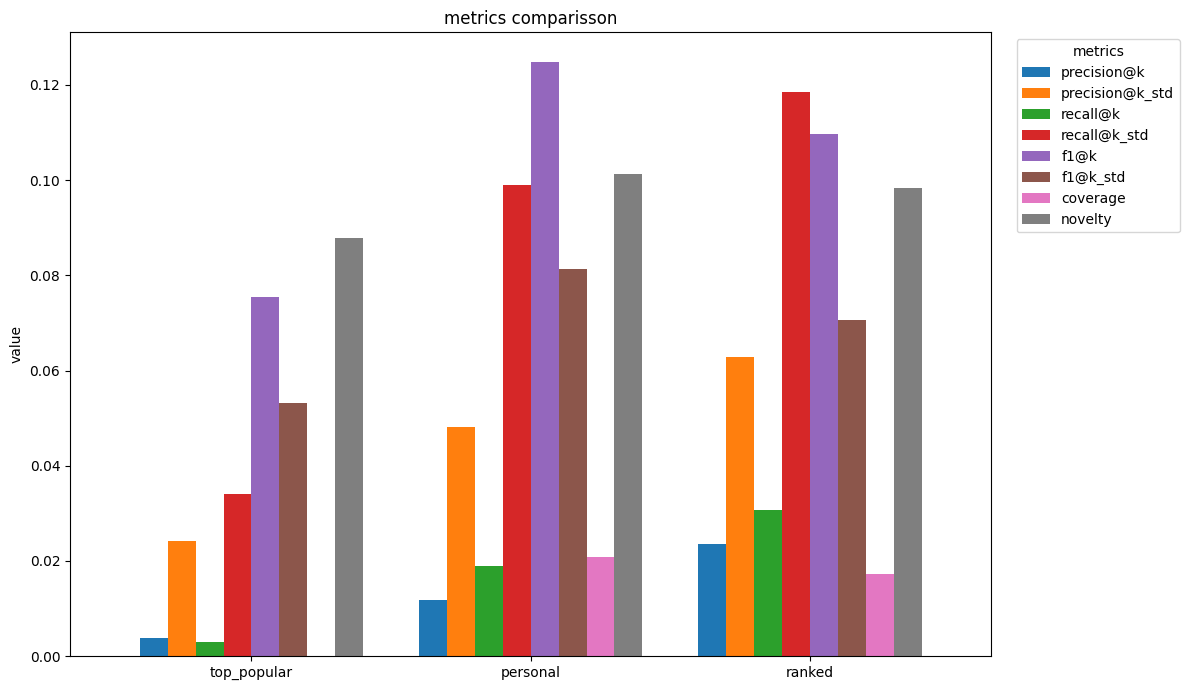

In [44]:
model_data = {
    "top_popular": top_popular_sample,
    "personal": personal_sample,
    "ranked": ranked_sample
}

metrics = {}
for model_name, recs_df in model_data.items():
    metrics[model_name] = calculate_metrics(recs_df, eval_gt_sample, k=TOP_K)

comparison = pd.DataFrame(metrics).T.reset_index(names="model")

try:
    numeric_cols = comparison.select_dtypes(include=["number"]).columns
    display(comparison.style.format({col: "{:.6f}" for col in numeric_cols}))
except Exception:
    display(comparison)


comparison.set_index("model").plot(kind="bar", figsize=(12, 7), rot=0,width=0.8)
plt.title("metrics comparisson")
plt.ylabel("value")
plt.xlabel("")
plt.legend(title="metrics", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Рекомендация на будущее: внедрить кросс-валидацию по времени (time-based CV) для более реалистичной оценки качества и предотвращения утечек данных в признаках.

The analysis reveals that the RANKED system significantly outperforms the other approaches across all key metrics, particularly in precision, recall, coverage, and F1 score.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Хорошая работа! Ты создала полноценный пайплайн рекомендательной системы production-уровня. Я увидел понимание важных аспектов работы с большими данными от эффективного управления памятью через правильные типы данных и ленивую загрузку до алгоритмических оптимизаций с использованием argpartition и битовой упаковки. Отметил правильный баланс между производительностью и читаемостью кода, это похвально. 
    
Единственная существенная проблема - утечка данных при создании признаков. Продолжай в том же духе!